In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as st
import RELACS as rel
sns.set_style("white")
sns.set_context("paper")
%load_ext rpy2.ipython
%matplotlib inline

/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/package/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Estimate bulck changes of histone modifications consequent to EPZ treatment using RELACS double ratio method 

In [ ]:
%%bash

### count reads in Bam for DMSO and EPZ NPC48h ###

for i in ../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_iNPC/filtered_bam/iNPC*rep*.bam ; do \
echo $(basename $i) | tr "\n" "\t" >> ../INPUT_DATA/counts_NPC48h_consensusSetAllPeaks.txt ; samtools view -c -L ../INPUT_DATA/EnrichedRegions_allMarks_normed_binned.bed $i >> ../INPUT_DATA/counts_NPC48h_consensusSetAllPeaks.txt; done

In [ ]:
%%bash

### count reads in Bam for DMSO and EPZ mESC ###

for i in ../../../../reference_datasets/Ferrari_mESC-iNPC_DMSOvsEPZ_fullEpigenomes_MERGED/output_DNA-mapping_snakepipe_mESC/filtered_bam/mESC*rep*.bam ; do \
echo $(basename $i) | tr "\n" "\t" >> ../INPUT_DATA/counts_mESC_consensusSetAllPeaks.txt ; samtools view -c -L ../INPUT_DATA/EnrichedRegions_allMarks_normed_binned.bed $i >> ../INPUT_DATA/counts_mESC_consensusSetAllPeaks.txt; done

In [3]:
### CREATE REFERENCE DATAFRAME FOR NPC48h ###

reads_NPC = pd.read_csv("../INPUT_DATA/counts_NPC48h_consensusSetAllPeaks.txt", sep="\t", names=["sample", "read_counts"])
reads_NPC["rep"] = [i.split("_")[2] for i in reads_NPC["sample"]]
reads_NPC["treat"] = [i.split("_")[1] for i in reads_NPC["sample"]]
reads_NPC["mark"] = [i.split("_")[3].split(".")[0] for i in reads_NPC["sample"]]
reads_NPC

,sample,read_counts,rep,treat,mark
0,iNPC_DMSO_rep1_H3K27ac_merged.filtered.bam,3108668,rep1,DMSO,H3K27ac
1,iNPC_DMSO_rep1_H3K27me3_merged.filtered.bam,4420814,rep1,DMSO,H3K27me3
2,iNPC_DMSO_rep1_H3K36me3_merged.filtered.bam,9271276,rep1,DMSO,H3K36me3
3,iNPC_DMSO_rep1_H3K4me1_merged.filtered.bam,3578157,rep1,DMSO,H3K4me1
4,iNPC_DMSO_rep1_H3K4me3_merged.filtered.bam,4579274,rep1,DMSO,H3K4me3
5,iNPC_DMSO_rep1_H3K79me2_merged.filtered.bam,8726767,rep1,DMSO,H3K79me2
6,iNPC_DMSO_rep1_H3K9me3_merged.filtered.bam,3614519,rep1,DMSO,H3K9me3
7,iNPC_DMSO_rep1_Input.filtered.bam,2378340,rep1,DMSO,Input
8,iNPC_DMSO_rep2_H3K27ac_merged.filtered.bam,6451688,rep2,DMSO,H3K27ac
9,iNPC_DMSO_rep2_H3K27me3_merged.filtered.bam,7173790,rep2,DMSO,H3K27me3


In [4]:
### CREATE REFERENCE DATAFRAME FOR mESC ###

reads_ESC = pd.read_csv("../INPUT_DATA/counts_mESC_consensusSetAllPeaks.txt", sep="\t", names=["sample", "read_counts"])
reads_ESC["rep"] = [i.split("_")[2] for i in reads_ESC["sample"]]
reads_ESC["treat"] = [i.split("_")[1] for i in reads_ESC["sample"]]
reads_ESC["mark"] = [i.split("_")[3].split(".")[0] for i in reads_ESC["sample"]]
reads_ESC

,sample,read_counts,rep,treat,mark
0,mESC_DMSO_rep1_H3K27ac_merged.filtered.bam,32975824,rep1,DMSO,H3K27ac
1,mESC_DMSO_rep1_H3K27me3_merged.filtered.bam,15283463,rep1,DMSO,H3K27me3
2,mESC_DMSO_rep1_H3K36me3_merged.filtered.bam,26342999,rep1,DMSO,H3K36me3
3,mESC_DMSO_rep1_H3K4me1_merged.filtered.bam,18586000,rep1,DMSO,H3K4me1
4,mESC_DMSO_rep1_H3K4me3_merged.filtered.bam,21817453,rep1,DMSO,H3K4me3
5,mESC_DMSO_rep1_H3K79me2_merged.filtered.bam,8199976,rep1,DMSO,H3K79me2
6,mESC_DMSO_rep1_H3K9me3_merged.filtered.bam,10925542,rep1,DMSO,H3K9me3
7,mESC_DMSO_rep1_Input.filtered.bam,9136221,rep1,DMSO,Input
8,mESC_DMSO_rep2_H3K27ac_merged.filtered.bam,45477406,rep2,DMSO,H3K27ac
9,mESC_DMSO_rep2_H3K27me3_merged.filtered.bam,14146795,rep2,DMSO,H3K27me3


-0.33130915417615286
-0.13012267211145256
-0.16989598665668712
-0.044954402147118044
-0.1094370554416545
-0.051730663179535535
-0.646242374476233
0.0


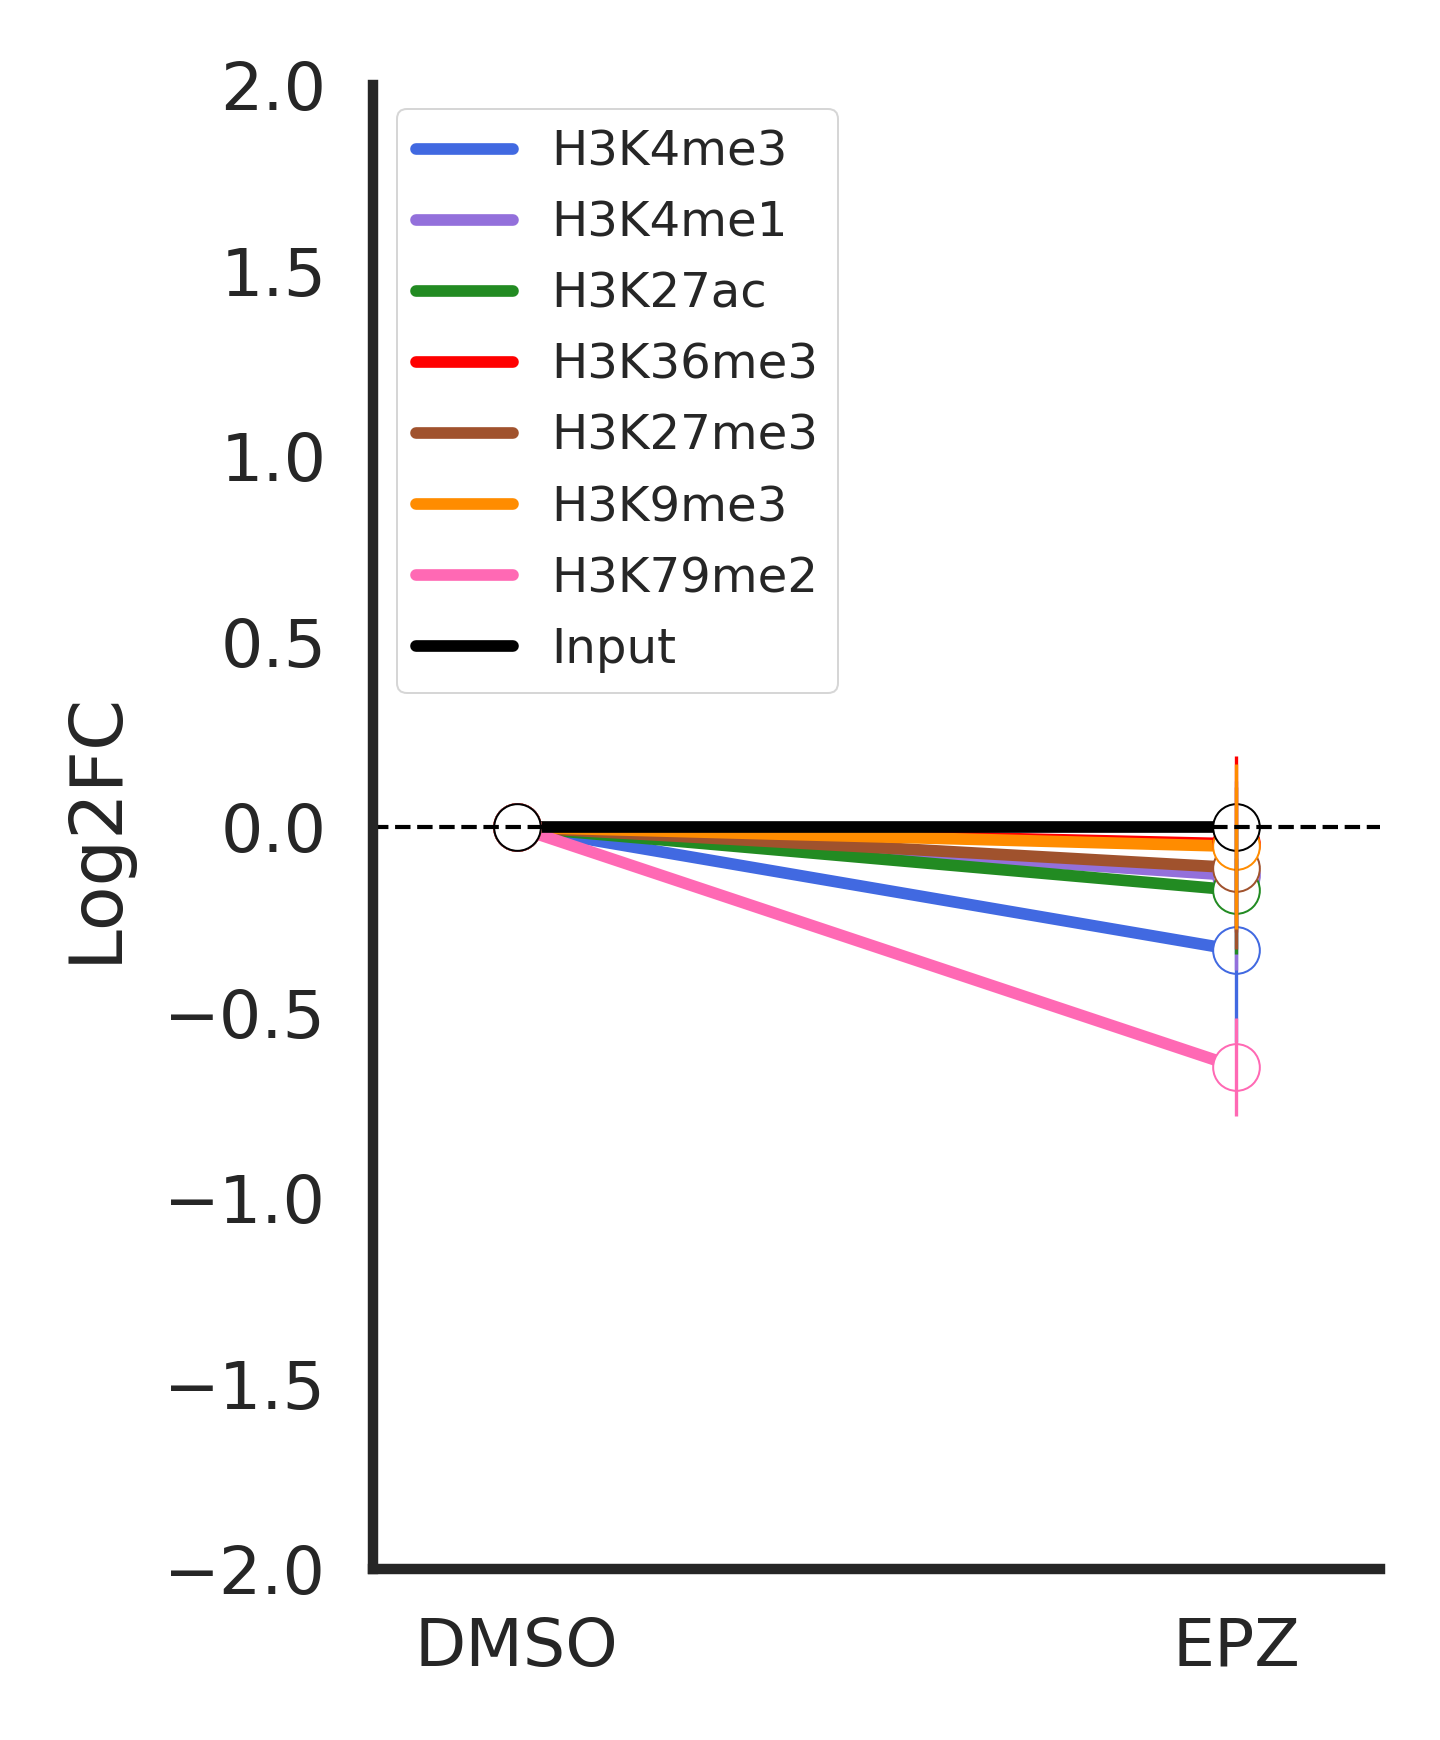

In [6]:
fig,ax = plt.subplots(dpi=600, figsize=(2.5,3))

cols={"H3K4me3":'royalblue',
      "H3K4me1":'mediumpurple',
      "H3K27ac":'forestgreen',
      "H3K36me3":'r',
      "H3K27me3":'sienna',
      "H3K9me3":'darkorange',
      "H3K79me2":'hotpink',
      "Input":'k'}

for i in ["H3K4me3","H3K4me1","H3K27ac","H3K36me3","H3K27me3","H3K9me3","H3K79me2","Input"]:#set(list(df_wt.mark)):
    
    inp = reads_NPC.loc[reads_NPC.mark == "Input"][["read_counts"]]
    

    markss = reads_NPC.loc[reads_NPC.mark == i][["read_counts"]]
#     print(markss)

    norm = markss.values/inp.values
    
   
    ratios = []
    for k in norm:
        a = list()
        for j in norm:
            a.append(k/j)
        ratios.append(list(a))
    iNPC = np.mean(np.log2(np.array(ratios)[2:,:2]))
    iNPC_std = np.std(np.log2(np.array(ratios)[2:,:2]))
#     mESC = np.mean(np.log2(np.array(ratios)[2:,:2]))
   
    ax.plot([0,1],[0,iNPC], label = i, zorder=0, color=cols[i])
    ax.errorbar([1],[iNPC],  yerr=iNPC_std, linewidth=0.4, capsize=0, color=cols[i])
    print(iNPC)
    ax.scatter([0,1],[0,iNPC], zorder=1,color=cols[i],edgecolor=cols[i], alpha=1, facecolor='white')
    
    ax.set_xticks(np.array([0,1]))
    ax.set_xticklabels(["DMSO","EPZ"])

    ax.legend(fontsize="xx-small", loc=2, frameon=True)
ax.set_ylabel("Log2FC")
ax.set_ylim(-2,2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(-0.2,1.2)
ax.axhline(0, linewidth=0.5,linestyle='--', color='k')
plt.tight_layout()

plt.savefig("../FIGURES/Global_Change_NPC48h_EPZvsDMSO.pdf")